This notebook intends to describe how the routines from the `naima` software package (https://arxiv.org/abs/1509.03319) are used to compute the synchrotron and inverse Compton emission in the one-zone synchrotron self-Compton (SSC) model applied in the paper MAGIC Collaboration et al., 2021, submitted to Astronomy & Astrophysics. The paper presents a detailed multiwavelength study of the blazar Mrk 421. 

We refer the user to https://naima.readthedocs.io/en/latest/ for a description of the modules and functions included in the `naima` package. 

To start, let us import all the necessary libraries to produce the results: naima, numpy, astropy (for units and physical constants), and matplotlib (for plotting purposes).

In [1]:
import naima as na
import numpy as np
import astropy.units as u
from astropy.constants import c, m_e
import matplotlib.pyplot as plt

import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)


Let us now define the parameters related to the source itself. We assume here a cosmology with $\Omega_m=0.3$, $\Omega_\Lambda=0.7$ and $H_0=70$ km s$^{-1}$ Mpc$^{-1}$. Given that the redshift of Mrk 421 is $z=0.031$ (de Vaucouleurs et al. 1991), this results in a luminosity distance of the source of $d_L=136$ Mpc. We further make the assumption that the Doppler factor of the emitting zone is $\delta=25$.

In addition, we assume the source to be a spherical blob with a radius $R$. The blob is embedded in a homogeneous magnetic field $B$. 
For simplicity and as an example, this notebook focuses on the SSC model shown in the top left plot from Figure 15 of the paper, corresponding to the SED on 2017 January 2017 (MJD 57757). For this day, the values found to well reproduce the observations are $R=10^{16}$ cm and $B=6.1 \times 10^{-2}$ G. 

In [2]:
#Luminosity distance
Lum_dist = 136 * u.Mpc

#Doppler factor
doppler_factor = 25
#Magnetic field    
B = 6.1e-2 * u.G
#Blob radius
R = 1e16 * u.cm

The blob is filled with a population of relativistic electrons. In the paper, we assume a broken power-law distribution:
\begin{equation}
N(\gamma) \propto \gamma^{-\alpha_1}, \quad \gamma_{min}<\gamma<\gamma_{br} \\
N(\gamma) \propto \gamma_{br}^{\alpha_2-\alpha_1} \gamma^{-\alpha_2}, \quad \gamma_{br}<\gamma<\gamma_{max}
\end{equation}
where $\gamma$ is electron Lorentz factor. $\gamma_{br}$ defines the location of the break. $\gamma_{min}$ and $\gamma_{max}$ are the minimum and maximum Lorentz factors, respectively. $\alpha_1$ and $\alpha_2$ are the slope before and after the break Lorentz factor $\gamma_{br}$. The electron population has an energy density of $u_e$ erg/cm$^{3}$.

The parameters value for the modelling of the SED on 2017 January 2017 (MJD 57757) are the following:

In [3]:
#Electron energy distribution parametrisation

##spectral parameters
gamma_min = 1e3
gamma_break = 2.1e5
gamma_max = 1.5e6
alpha_1 = 2.2
alpha_2 = 3.8

##energy density
u_e = 1.1e-2 * u.erg/(u.cm**3)

In order to initialise the electron distribution, one uses the `na.models.BrokenPowerLaw()` class from the `naima` package. Since `na.models.BrokenPowerLaw()` uses as arguments the energy of the electrons instead of their Lorentz factor, we introduce a very simple function `gamma_to_E()` that is making the conversion from Lorentz factor to energy.  

In [4]:
def gamma_to_E(gamma):

    E = gamma * (m_e*c**2).to(u.eV)

    return E

E_min = gamma_to_E(gamma_min)
E_break = gamma_to_E(gamma_break)
E_max = gamma_to_E(gamma_max)

#Initialisation of the electron distribution
#We normalise the distribution to a dummy value of 1 [eV^-1], which will anyhow be changes later.
#The normalisation energy is set to 1 eV 
EDIS = na.models.BrokenPowerLaw(1*u.Unit('1/eV'), 1*u.eV, 
                                E_break, alpha_1, alpha_2)

Before moving to the emission processes, we define the energy range over which we wish to compute the synchrotron and inverse Compton emissions. We define energies for the emission both in the observer's frame and comoving frame.

In [5]:
spectrum_energy_obs = np.logspace(-10, 20, 500)*u.eV
spectrum_energy_comov = spectrum_energy_obs/doppler_factor

We now compute the synchrotron emission using `na.models.Synchrotron()` and giving as argument the electron distribution `EDIS` and the magnetic field $B$. It is computed for electrons with energies from `E_min` to `E_max`. Then, using the function `set_We()` the synchtoron emission is computed for an electron distribution normalised at a total energy of $\frac{4}{3} \pi R^3 \, u_e$.

In [6]:
#Synchrotron emission
SYN = na.models.Synchrotron(EDIS, B,
                            Eemin=E_min , Eemax=E_max)
SYN.set_We(u_e * (4/3) * np.pi * R**3, 
           Eemin=E_min, Eemax=E_max)


We now compute the inverse Compton emission. For this, the target synchrotron photon density `phn_sy` for the scattering needs to be calculated. This is achieved by computing the synchrotron luminosity `Lsy` and divide it by $4 \pi R^2 c$. An additional factor 2.24 arises for geometric arguments and is due to the fact that we consider a uniform spherical emitting blob (see Atoyan & Aharonian,1996, https://ui.adsabs.harvard.edu/abs/1996MNRAS.278..525A/abstract)

In [7]:
#Inverse Compton (IC) emission
##First, compute synchrotron photons target density for the IC process

Lsy = SYN.flux(spectrum_energy_comov, distance=0*u.Mpc) #computing the flux at distance 0 returns the luminosity 
phn_sy =  2.24*(spectrum_energy_comov)**2 *Lsy / (4 * np.pi * R**2 * c.to(u.cm/u.s) ) 


##IC flux computation
IC = na.models.InverseCompton(EDIS, 
                              seed_photon_fields=[['SSC', spectrum_energy_comov, phn_sy]], 
                              Eemin=E_min , 
                              Eemax=E_max)

IC.set_We(u_e * (4/3) * np.pi * R**3, 
          Eemin=E_min, Eemax=E_max)


The last step consists in including the relativistic Doppler effects. The SED measured in the observer's frame will be $\nu F_{\nu}(\nu)= \delta^4 \nu' F'_{\nu'}(\nu')$, where unprimed quantities are in the observer's frame and primed quantities are in the comoving frame. 

In [8]:
obs_flux_SYN = doppler_factor**4 * (spectrum_energy_comov)**2 * SYN.flux(spectrum_energy_comov, distance=Lum_dist)
obs_flux_IC = doppler_factor**4 * (spectrum_energy_comov)**2 * IC.flux(spectrum_energy_comov, distance=Lum_dist) 


We can now finally plot the resulting SED. We express it in erg/cm$^{2}$/s versus Hz, as commonly done in astrophysics. We also add on top a X-axis in eV, for convenience.

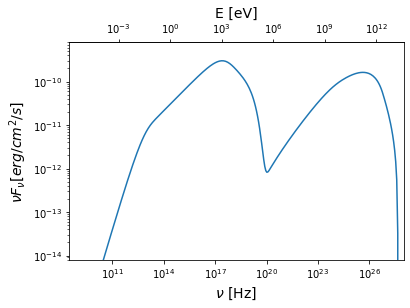

In [9]:
fig, axs = plt.subplots()

axs.plot(spectrum_energy_obs.to(u.Hz, equivalencies=u.spectral()), (obs_flux_SYN+obs_flux_IC).to(u.erg*u.cm**(-2)*u.s**(-1)), '-')

axs.set_xscale('log')
axs.set_yscale('log')

axs.set_xlim(3e8, 1e28)
axs.set_ylim(8e-15, 8e-10)

axs.set_xlabel(r'$\nu$ [Hz]', fontsize=14)
axs.set_ylabel(r'$\nu F_{\nu} [erg/cm^2/s]$', fontsize=14)

#Add x axis on top with eV scale

def forward(x):
    Hz_to_eV = 4.1357e-15
    return x*Hz_to_eV


def inverse(x):
    eV_to_Hz = (4.1357e-15)**-1
    return x*eV_to_Hz


eV_ax = axs.secondary_xaxis('top', functions=(forward, inverse))
eV_ax.set_xlabel('E [eV]', fontsize=14)


plt.show()